In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import scipy.stats
import scipy.ndimage
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

cosmo = Planck13

In [4]:
os.chdir("/home/mitchell/Documents/masters/masters/data/server/run_45_lr_flip/outputs")
os.getcwd()
output = np.loadtxt('output_776000_pairs.txt',delimiter=',')
output = (output + np.flipud(output))/2

def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius
  return mask

cen = (169/2+1,169/2+1)
out_mask = radMask(cen,80,output).astype(int)
in_mask = radMask(cen,60,output).astype(int)
annul_mask = np.subtract(out_mask,in_mask).astype(bool)
annular_mean = sp.ndimage.mean(output,labels = annul_mask)
output_less_mean = output-annular_mean
# print(annular_mean)
# print(output_less_mean)
lft_halo = output[:,44]
centre = int(len(output)/2)+1



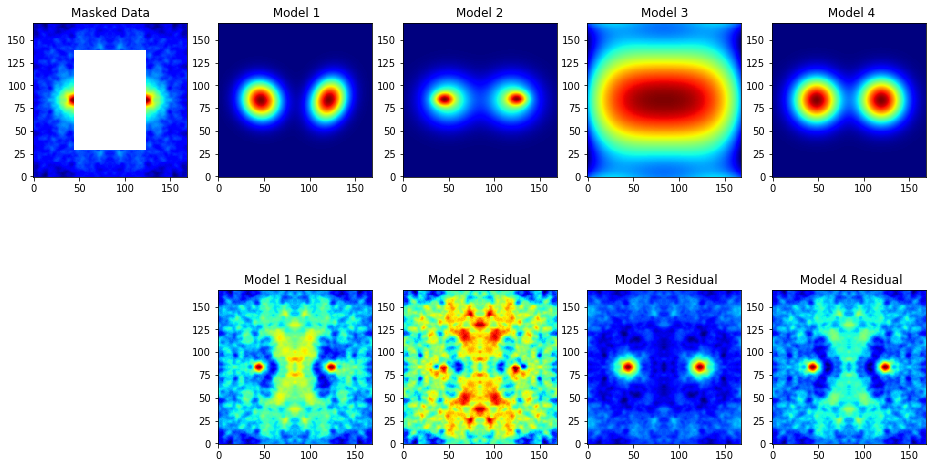

In [8]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

@custom_model
def sum_of_2Dgaussians(x, y, amplitude=1., mean_x1=0., mean_y1=0., mean_x2=0., mean_y2=0., sigma_x=1.,sigma_y=1.):
    return amplitude * np.exp(-( (x-mean_x1)**2/2./sigma_x**2 + (y-mean_y1)**2/2./sigma_y**2 ) ) \
        + amplitude * np.exp(-( (x-mean_x2)**2/2./sigma_x**2 + (y-mean_y2)**2/2./sigma_y**2 ) )

@custom_model
def spherical_of_2Dgaussians(x, y, amplitude=1., mean_x1=0., mean_y1=0., mean_x2=0., mean_y2=0., sigma=1.):
    return amplitude * np.exp(-( (x-mean_x1)**2/2./sigma**2 + (y-mean_y1)**2/2./sigma**2 ) ) \
        + amplitude * np.exp(-( (x-mean_x2)**2/2./sigma**2 + (y-mean_y2)**2/2./sigma**2 ) )

@custom_model
def sum_of_exponential_2D(x, y, decay_x = 0., cen_x1=0., cen_x2 = 0., decay_y = 0., cen_y1 = 0., cen_y2 = 0.):
    return (np.exp(- decay_x*(x-cen_x1) - decay_y*(y-cen_y1)) \
                      + np.exp(- decay_x*(x-cen_x2) - decay_y*(y-cen_y2)))

fit_data = np.ma.masked_array(output, mask=np.zeros_like(output))
fit_data.mask[30:169-30,45:169-45] = True 

# p_init = models.Polynomial2D(degree=4)
g1_init = models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Const2D(amplitude=1e-7) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=45, y_mean=85, x_stddev=5, y_stddev=5) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=125, y_mean=85, x_stddev=5, y_stddev=5) 
fit_g1 = fitting.LevMarLSQFitter()

g2_init = sum_of_2Dgaussians(amplitude=1e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + sum_of_2Dgaussians(amplitude=4e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + models.Const2D(amplitude=1e-7)
fit_g2 = fitting.LevMarLSQFitter()

g3_init = models.Polynomial2D(degree=4)#*\
#    sum_of_exponential_2D(amplitude=4e-7, decay_x = 12, cen_x1=45, cen_x2 = 125, decay_y = 12, cen_y1 = 85, cen_y2 = 85)
fit_g3 = fitting.LevMarLSQFitter()

g4_init = spherical_of_2Dgaussians(amplitude=1e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma=12) \
    + models.Const2D(amplitude=1e-7)
fit_g4 = fitting.LevMarLSQFitter()

y,x = np.mgrid[:len(output),:len(output)]

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    g1 = fit_g1(g1_init, x, y, fit_data)
    g2 = fit_g2(g2_init,x,y,fit_data)
    g3 = fit_g3(g3_init,x,y,fit_data)
    g4 = fit_g4(g4_init,x,y,fit_data)



    
plt.figure(figsize=(16,9))
plt.title("2D Model Fitting",size=15)
plt.subplot(2, 5, 1)
plt.imshow(fit_data, origin='lower', interpolation='nearest',cmap='jet')
plt.title("Masked Data")

plt.subplot(2, 5, 2)
plt.imshow(g1(x, y), origin='lower', interpolation='nearest',cmap='jet')
plt.title(" Model 1")

plt.subplot(2, 5, 7)
plt.imshow(output_less_mean - g1(x, y), origin='lower', interpolation='nearest',cmap='jet')
plt.title("Model 1 Residual")

plt.subplot(2, 5, 3)
plt.imshow(g2(x,y), origin='lower', interpolation='nearest',cmap='jet')
plt.title(r"Model 2")

plt.subplot(2,5,8)
plt.imshow(output_less_mean-g2(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(r"Model 2 Residual")

plt.subplot(2,5,4)
plt.imshow(g3(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title("Model 3")

plt.subplot(2,5,9)
plt.imshow(output_less_mean-g3(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(" Model 3 Residual")

plt.subplot(2,5,5)
plt.imshow(g4(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(" Model 4")

plt.subplot(2,5,10)
plt.imshow(output_less_mean-g4(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(" Model 4 Residual")

os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("Presentation_2D_data_fitting.png",dpi=800)